# Assignment One

In [119]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import geopandas
from shapely.geometry import Point
import censusgeocode as cg
import datetime as dt

## Problem 1

### Functions 

In [357]:
def pull_community(link):
    '''
    This function pulls in the community boundary area for Chicago.

    link: API link

    returns: dictionary with community number as key, community name as value
    '''

    response = requests.get(link)
    d = response.json()

    comm_dict = []

    for comm in d:
        k = comm['area_num_1']
        l = comm['community']
        new = {'community_area': k, 'name': l}
        comm_dict.append(new)

    return pd.DataFrame(comm_dict)

    
def pull_data(api_link, inc = 50000):
    '''
    This function pulls data from the api_link and organizes it into a pandas dataframe.

    api_link: string containing api url
    inc: increment for data pull since api only returns (max) 50000 items at a time

    returns: dataframe
    '''

    off = 0

    full = []

    while True:
        url = f'{api_link}?$limit={inc}&$offset={off}'
        response = requests.get(url, timeout = 10)
        data = response.json()
        if data:
            full += data
            off += inc
        else: #empty response
            break

    return pd.DataFrame(full)

def avg_crime_nhood(*args):
    '''
    This function finds the mean number of crimes per community area.
    
    args: dataframes for each year 
    
    return: dataframe with community area and average crimes
    '''
    all_years = []
    
    for df in args:
        yr = df['year'].unique()[0]
        by_nhood = df.groupby(['community_area', 'primary_type']).count()[['id']]
        by_nhood = by_nhood.reset_index()
        col_name = f'{yr} Total'
        by_nhood.columns = ['community_area', 'Type', col_name]
        all_years.append(by_nhood)

    final_counts = pd.merge(all_years[0], all_years[1], on = ['community_area','Type'], how='outer')
    final_counts = final_counts.fillna(0)
    col1 = final_counts.columns[2]
    col2 = final_counts.columns[3]
    final_counts['Average'] = round((final_counts[col2]+final_counts[col1])/2,1)
    final_counts['Percent Change'] = round((final_counts[col2]/final_counts[col1] -1)*100,1)
    final_counts['Type']=final_counts['Type'].str.capitalize()
        
    return final_counts

def num_crimes_type(*args):
    '''
    This function calculates the total number of crimes committed across all 
    dataframes inputted.

    *args: dataframes containing crime records (each row is a crime)

    return: integer with number of crimes
    '''

    all_years = []

    for df in args:
        yr = df['year'].unique()[0]
        #print(yr)
        by_type = df.groupby('primary_type').count()[['id']]
        by_type = by_type.reset_index()
        col_name = f'{yr} Total'
        by_type.columns = ['Type', col_name]
        all_years.append(by_type)

    final_counts = pd.merge(all_years[0], all_years[1], on = 'Type')
    col1 = final_counts.columns[1]
    col2 = final_counts.columns[2]
    final_counts['Percent Change'] = round((final_counts[col2]/final_counts[col1]-1)*100,1)
    final_counts['Type']=final_counts['Type'].str.capitalize()

    return final_counts


def mk_table(data, filename = 'table.png', dpi = 800, scale=False, fontsize = False):
    '''
    This function makes a matplotlib table from a pandas dataframe.

    data: pandas dataframe
    filename: filename to save table png
    dpi = resolution

    '''
    plt.figure(figsize=(8,6))
    plt.axis('off')

    cell_text = []
    for row in range(len(data)):
        cell_text.append(data.iloc[row])

    tab = plt.table(cellText=cell_text, 
        colLabels=data.columns, 
        loc='center')

    if fontsize:
        tab.auto_set_font_size(False)
        tab.set_fontsize(5)
    if scale:
        tab.scale(1.25,3)
        
    plt.savefig(filename, dpi = dpi, bbox_inces='tight')

def mk_bar(df, x_col, y_col, title, filename = 'bar.png', dpi = 500):
    '''
    This function makes a horizontal bar chart from a dataframe.

    df: dataframe
    x_col: name of column for the x-axis argument in the plot
    y_col: name of column for the y-axis argument in the plot
    filename: filename to save barchart png
    dpi = resolution

    return: None
    '''

    df = df.sort_values(y_col, ascending=True)
    df.plot.barh(x=x_col, y=y_col, legend = None)
    plt.title(title)
    plt.tick_params(axis='y', which='major', labelsize=6.5)
    plt.savefig(filename, bbox_inches='tight', dpi=400)
    
def most_common_yr(df, year = 2018):
    '''
    This function builds a dataframe that finds the most common crime type for each community area and aggregates to be used
    in a pie chart.
    
    df: dataframe from avg_crime_nhood
    
    returns: dataframe
    '''
    
    dict_n = []
    tgt_col = f'{year} Total'

    #make pie chart of the 3?
    for c in df['community_area'].unique():
        new = df[df['community_area']== c].sort_values(tgt_col, ascending=False)
        top = new.iloc[0]
        n = {'Type': top['Type'], tgt_col: top[tgt_col], 'area': top['community_area']}
        dict_n.append(n)
    
    return pd.DataFrame(dict_n)
    
    
def mk_pie(df, year, filename = 'pie.png', dpi=500):
    '''
    This function makes a pie chart from a given dataframe.
    
    df: dataframe from most_common_yr
    
    returns: None
    '''
    
    df.set_index('Type', inplace=True, drop=True)
    final = df.groupby('Type').count()
    
    tgt_col = f'{year} Total'
    
    final.plot.pie(y=tgt_col, legend=None,
                   autopct='%1.0f%%',pctdistance=0.75, 
                   title = f'Most Common Type of Crime in {year}\n(by Community Area)')
    plt.axis('off')
    plt.savefig(filename, dpi=dpi)
    
def summary_nhood(df, area_num):
    '''
    This function creates a table summary of type of crime in 2017 and 2018 of a particular community area
    as well as a bar chart of the percent change.
    
    df: dataframe from avg_crime_nhood
    area_num: community_area number
    
    returns: None
    '''
    
    filtered = df[df['community_area'] == str(area_num)]
    filtered = filtered.set_index('community_area')
    
    f1 = f'nhood_{area_num}.png'
    mk_table(filtered, filename = f1)
    
    f2 = f'nhood_bar_{area_num}.png'
    title = f'Average Number of Crimes by Type (2017 to 2018)\nCommunity Area: {area_num}'
    mk_bar(filtered, 'Type', 'Average', title, f2)
    
    
    

In [5]:
# Links to use
crime_2017_api = 'https://data.cityofchicago.org/resource/d62x-nvdr.json'
crime_2018_api = 'https://data.cityofchicago.org/resource/3i3m-jwuy.json'

In [6]:
df1 = pull_data(crime_2017_api)
df2 = pull_data(crime_2018_api)

In [358]:
#summary stats
x = num_crimes_type(df1, df2)

z = avg_crime_nhood(df1, df2)
a = most_common_yr(z)
b = most_common_yr(z, 2017)

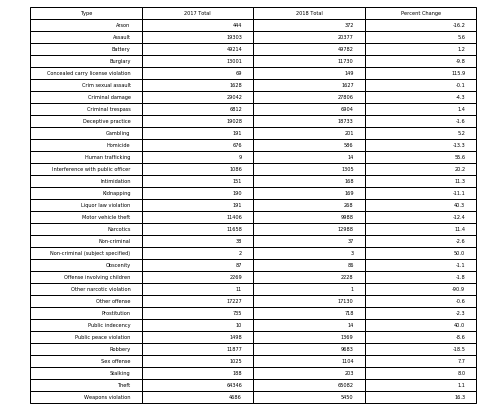

In [43]:
mk_table(x, 'table_by_type.png')

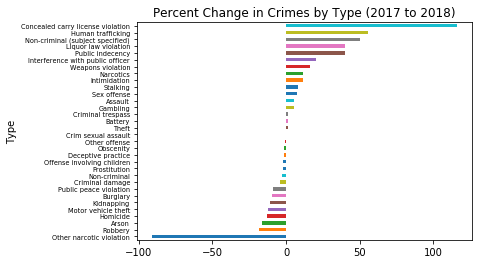

In [111]:
mk_bar(x, 'Type', 'Percent Change', 'Percent Change in Crimes by Type (2017 to 2018)', 'bar_type_chg.png')

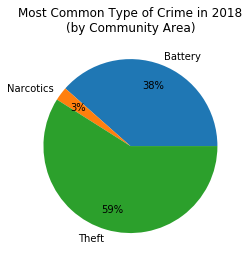

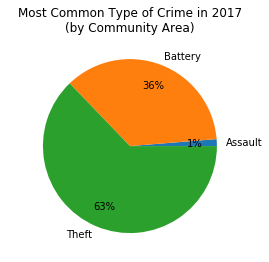

In [359]:
mk_pie(a, 2018, '2018 pie.png')
mk_pie(b, 2017, '2017 pie.png')

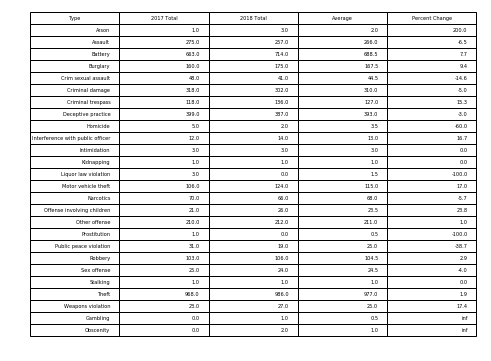

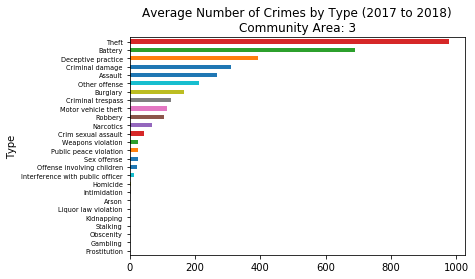

In [109]:
summary_nhood(z, '3')

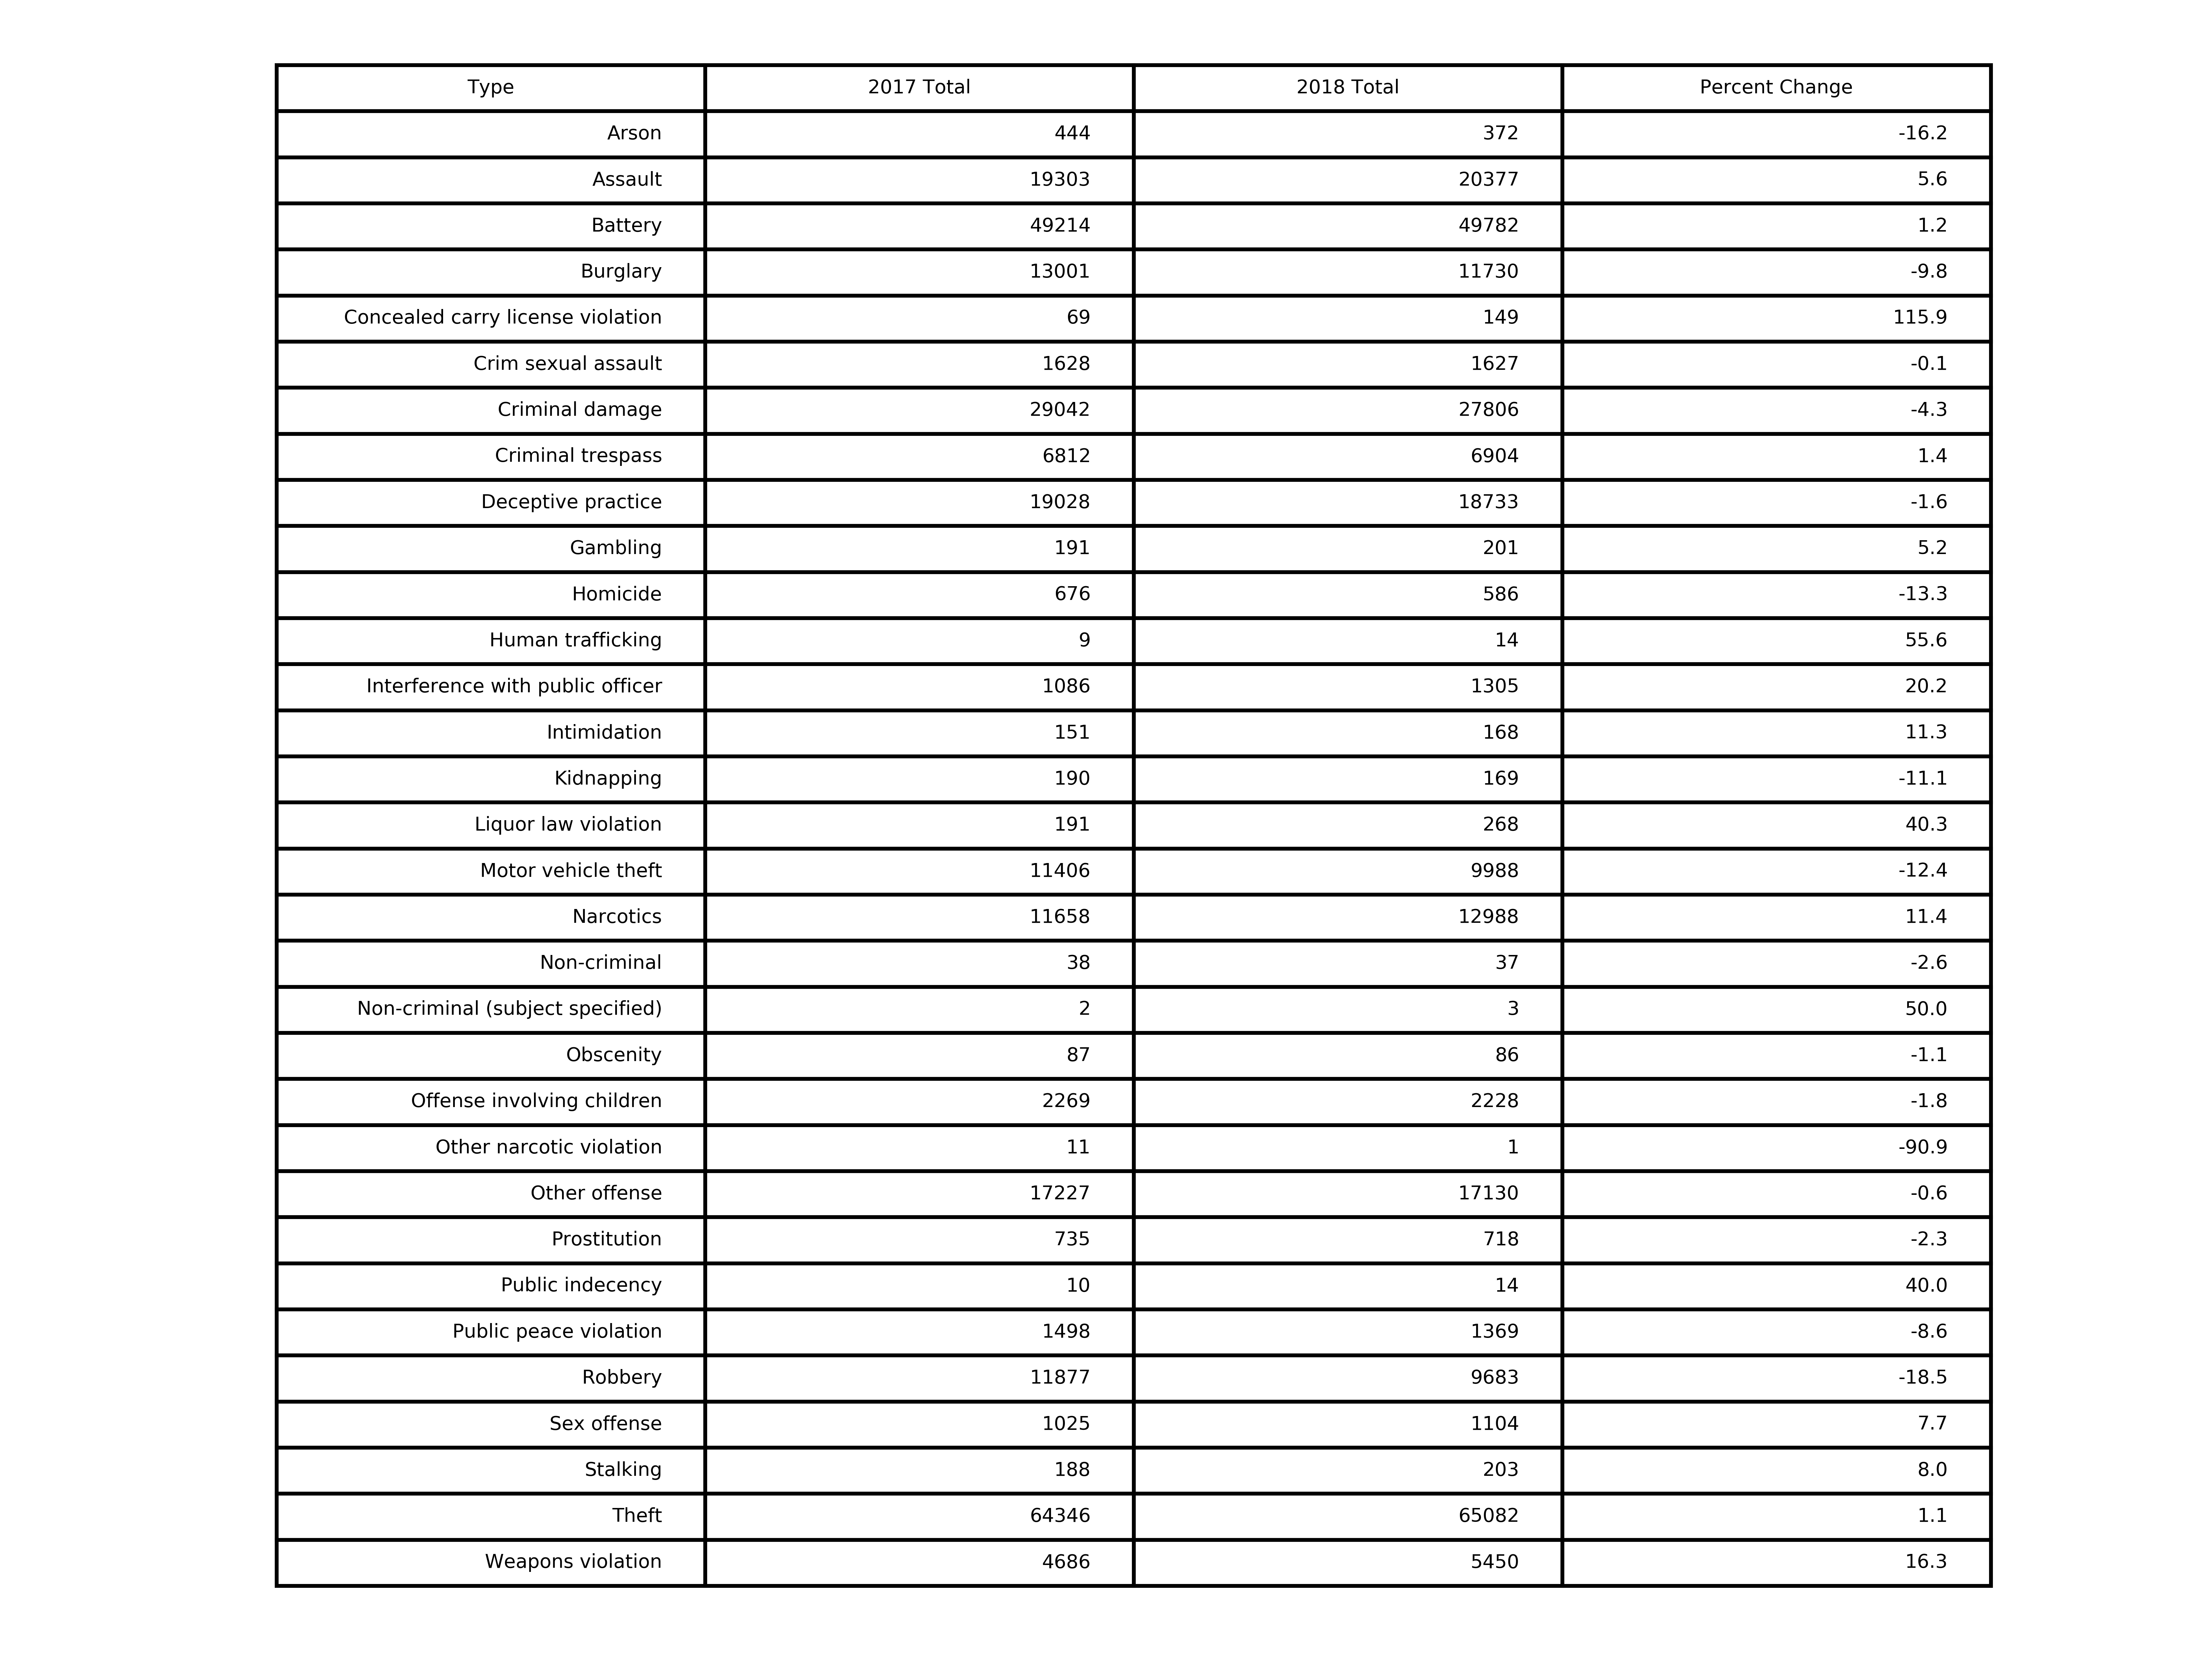

In [44]:
Image('table_by_type.png')

In [ ]:
Image('bar_type_chg.png')

In [ ]:
Image('2018 pie.png')

In [ ]:
Image('2017 pie.png')

In [ ]:
Image('nhood_3.png')

In [ ]:
Image('nhood_bar_3.png')

## Problem 2

### Functions

In [41]:
def get_acs_blk_data(state, county, filename = 'census_data.csv'):
    '''
    This function retrieves block group data from the census_api and saves it to a csv.
    
    state: state code for api geographical hierarchy
    county: county code for api geographical hierarchy
    
    returns: dataframe with all block groups for the state and county
    '''

    all_tracts = f'https://api.census.gov/data/2016/acs/acs5?get=NAME&for=tract:*&in=state:{state}+county:{county}'
    
    response = requests.get(all_tracts)
    data = response.json()
    tracts_list = [x[-1] for x in data[1:]]

    full_census_data = 'empty'
    count=0
    for t in tracts_list:
        count +=1
        #print(count)
        blkgrp = f'https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:{state}+county:{county}+tract:{t}&key=48b45a2062a735ab2c6960def7d8cd8223041485'
        #print(blkgrp)
        response = requests.get(blkgrp)
        data = response.json()
        #print(data)

        df = pd.DataFrame(data)

        if type(full_census_data) == str:
            full_census_data = df
        else:
            full_census_data = pd.concat([full_census_data, df[1:]], ignore_index = True)

    full_census_data.to_csv(filename)
    return full_census_data

def find_tract_blk(lat, lng): 
    '''
    This function finds the census block info for a given latitude and longitude. Easy to use when only have one coordinate to check.
    
    lat: latitude
    lng: longitude
    
    return: FIPS census tract and block group code
    '''
    geo_info = cg.coordinates(x=lng,y=lat)
    block = geo_info['2010 Census Blocks'][0]['BLKGRP']

    tract = geo_info['2010 Census Blocks'][0]['TRACT']

    return tract+block



def ltlng_to_fips(df, geodf):
    '''
    This function uses spatial join to identify which the census blocks and tracts for data with latitude and longitude
    
    df: pandas dataframe with crime data
    geofile: geojson file with census block level data
    
    return: geodataframe 
    '''
    
    #add shapely Points to pandas dataframe
    df = df.dropna(subset=['latitude', 'longitude'])
    geometry = [Point(xy) for xy in zip(pd.to_numeric(df.longitude), pd.to_numeric(df.latitude))]
    df = df.drop(['longitude', 'latitude'], axis=1)
    crs = {'init': 'epsg:4326'}
    gdf = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    #join
    return geopandas.sjoin(gdf, geodf, how="inner", op='intersects')
    
def multiple_joins(types, df_list, geofile = 'block_bounds.geojson'):
    '''This function returns a dictionary of multiple spatial joins
    
    types: list of types to filter by
    df_list: list of dfs to do the join on
    
    returns: dictionary
    
    '''
    
    final = {}
    
    #read in geojson
    geodf =geopandas.read_file(geofile)
    
    for t in types:
        #print(t)
        for df in df_list:
            t = t.upper()
            yr = df['year'].unique()[0]
            #print(yr)
            tmp = df[df['primary type'] == t]
            #print(tmp)
            
            joined = ltlng_to_fips(tmp, geodf)
            
            t = t.capitalize()
            key = f'{t} ({yr})'
            final[key] = joined
            
    return final

def build_summary_table(metrics, dict_df):
    '''
    This function builds a summary table of characteristics for each crime type in dict_df
    
    metrics: list of metrics for summary table
    dict_df: dictionary of df with census info for that crime (results of block_summary)
    
    returns: summary dataframe
    '''
    
    summary_table = pd.DataFrame()
    summary_table['Descriptive Metrics: Average'] = metrics
    
    for k, v in dict_df.items():
        print(k)
    
        blk_list = get_blk_list(v)
        blk_sum = block_summary(blk_list, census_df)
        
        values = get_metrics(blk_sum, metrics)
        
        summary_table[k] = values
        
    return summary_table

def get_metrics(df_block_info, metrics):
    '''
    Get summary metrics for summary table
    
    df_block_info: dataframe for crime type with block information
    metrics: columns to average
    
    return: list of values
    '''
    summary = []
    for m in metrics:
        val = round(df_block_info[m].mean(),2)
        if 'P' in m.upper():
            val = f'{val}%'
        summary.append(val)
        
    return summary

def get_blk_list(crime_df, q_thresh = 0.75):
    '''
    This function identifies the blocks that had a certain amount of crime (set by q_thresh)
    
    crime_df: df with specific type of crime (battery, homicide, etc) for one year
    q_thresh: quantile threshold to determine which blocks to look at
    
    return: list of block groups as strings
    '''
    
    crime_df['block'] = crime_df['tractce10'] + crime_df['blockce10'].str.slice(stop=1)
    by_block = crime_df.groupby('block').count()[['id']]
    q = by_block['id'].quantile(q_thresh)
    filtered = by_block[by_block['id'] > q]
    
    return list(filtered.index)
    
def block_summary(block_list, all_census):
    '''
    This function returns summary statistics for given blocks.
    
    block_list: list of blocks to summarize
    all_census: census dataframe
    
    return: dataframe with summary stats per block group
    '''
    summary = []
    
    for blk in block_list:
        tract = int(blk[0:-1])
        block = int(blk[-1])
        
        census_df = all_census[(all_census.tract == tract) & (all_census.block == block)]
        
        med_age = census_df['Median Age'].iloc[0]
        if med_age < 0:
            continue
        
        total_hh = census_df['Total Households'].iloc[0]
        hhinc_less_25 = round((sum([census_df['Households < 10k'].iloc[0], census_df['10k < Household < 15k'].iloc[0], census_df['15k < Household < 20k'].iloc[0], census_df['20k < Household < 25k'].iloc[0]])/total_hh)*100,2)
        hhinc_25_50 = round((sum([census_df['25k < Household < 30k'].iloc[0], census_df['30k < Household < 35k'].iloc[0], census_df['35k < Household < 40k'].iloc[0], census_df['40k < Household < 45k'].iloc[0], census_df['45k < Household < 50k'].iloc[0]])/total_hh)*100,2)
        hhinc_50_100 = round((sum([census_df['50k < Household < 60k'].iloc[0], census_df['60k < Household < 75k'].iloc[0], census_df['75k < Household < 100k'].iloc[0]])/total_hh)*100,2)
        #hhinc_over_100 = round((1 - hhinc_less_25 - hhinc_25_50 - hhinc_50_100)*100,2)
        
        total_race = census_df['Total Hispanic'].iloc[0] + census_df['Total Not Hispanic'].iloc[0]
        pct_hisp = round((census_df['Total Hispanic'].iloc[0]/total_race)*100, 2)
        pct_white = round((census_df['Total White'].iloc[0]/total_race)*100, 2)
        pct_black = round((census_df['Total Black'].iloc[0]/total_race)*100, 2)
        pct_asian = round((census_df['Total Asian'].iloc[0]/total_race)*100, 2)
        
        
        tmp = {'Block': blk, 'Median Age': med_age, 'Pct household income < 25k': hhinc_less_25, '25k < Pct household income < 50k': hhinc_25_50,
              '50k < Pct household income < 100k': hhinc_50_100, 'Percent Hispanic': pct_hisp,
              'Percent White': pct_white, 'Percent Black': pct_black, 'Percent Asian': pct_asian}
        
        summary.append(tmp)
    #print(summary)
    return pd.DataFrame(summary)    


#### Pull in ACS 5Y 2017 Data

Variable information:


'B01002_001E': 'Median age',

'B19001': HOUSEHOLD INCOME IN THE PAST 12 MONTHS,

'B19001_001E': 'Total', 

'B19001_002E': 'Less than 10,000',

'B19001_003E': '10000 to 14999',

'B19001_004E': '15000 to 19999',

'B19001_005E': '20000 to 24999',

'B19001_006E': '25000 to 29999',

'B19001_007E': '30000 to 34999',

'B19001_008E': '35000 to 39999',

'B19001_009E': '40000 to 45999',

'B19001_010E': '45000 to 49999',

'B19001_011E': '50000 to 59999',

'B19001_012E': '60000 to 74999',

'B19001_013E': '75000 to 99999',

'B03002_012E': 'Estimate!!Total!!Hispanic or Latino', 

'B03002_002E': 'Estimate!!Total!!Not Hispanic or Latino',

'B03002_003E': 'Estimate!!Total!!Not Hispanic or Latino!!White alone',

'B03002_004E': 'Estimate!!Total!!Not Hispanic or Latino!!Black or African American alone',

'B03002_006E': 'Estimate!!Total!!Not Hispanic or Latino!!Asian alone',

In [ ]:
census_pull = get_acs_blk_data('17','031')

In [18]:
census_df = pd.read_csv('census_data.csv',skiprows=1)
census_df = census_df.drop('0', axis=1)
census_df.columns = ['Name', 'Median Age', 'Total Households', 'Households < 10k', '10k < Household < 15k',
                    '15k < Household < 20k','20k < Household < 25k','25k < Household < 30k',
                    '30k < Household < 35k','35k < Household < 40k','40k < Household < 45k',
                    '45k < Household < 50k', '50k < Household < 60k','60k < Household < 75k',
                    '75k < Household < 100k', 'Total Hispanic', 'Total Not Hispanic', 'Total White',
                    'Total Black', 'Total Asian', 'state', 'county', 'tract', 'block']


#### Compare different types of crime

In [48]:
joined1 = multiple_joins(['BATTERY', 'HOMICIDE'], [df1, df2])

joined2 = multiple_joins(['DECEPTIVE PRACTICE','SEX OFFENSE'], [df1, df2])

metrics = ['Median Age', 'Pct household income < 25k', '25k < Pct household income < 50k',
              '50k < Pct household income < 100k', 'Percent Hispanic',
              'Percent White', 'Percent Black', 'Percent Asian']

In [ ]:
tbl1 = build_summary_table(metrics, joined1)
tbl2 = build_summary_table(metrics, joined2)

In [ ]:
mk_table(tbl1, 'problem2_summary1.png', scale=True, fontsize=True)
mk_table(tbl2, 'problem2_summary2.png', scale=True, fontsize=True)

## Problem 3

In [164]:
ward_43_17 = df1[df1['ward']=='43']
ward_43_17['date'] = ward_43_17['date'].astype('datetime64[ns]')

ward_43_18 = df2[df2['ward']=='43']
ward_43_18['date'] = ward_43_18['date'].astype('datetime64[ns]')

/anaconda3/envs/geopdenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/geopdenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [165]:
type(ward_43_17['date'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [214]:
end_date_18 = pd.Timestamp(year=2018,month=7,day=26, hour = 23, minute= 59, second=59)
sub = pd.Timedelta('29 days')
start_date_18 = end_date_18 - sub

In [219]:
end_date_17 = pd.Timestamp(year=2017, month=7, day=26, hour = 23, minute= 59, second=59)
sub = pd.Timedelta('29 days')
start_date_17 = end_date_17 - sub

#start_date_17

In [220]:
filter_17 = ward_43_17[(ward_43_17['date'] >= start_date_17) & (ward_43_17['date'] <= end_date_17)]
filter_18 = ward_43_18[(ward_43_18['date'] >= start_date_18) & (ward_43_18['date'] <= end_date_18)]

In [221]:
tgt_types = ['ROBBERY', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'BATTERY']
count_17 = filter_17.groupby('primary_type').count()[['id']]
count_18 = filter_18.groupby('primary_type').count()[['id']]

In [222]:
rob_17 = count_17.loc['ROBBERY']
rob_18 = count_18.loc['ROBBERY']
pct_chg = rob_18/rob_17 -1
pct_chg*100

id   -52.941176
Name: ROBBERY, dtype: float64

In [171]:
burg_17 = count_17.loc['BURGLARY']
burg_18 = count_18.loc['BURGLARY']
(burg_18/burg_17 -1)*100

id   -12.5
Name: BURGLARY, dtype: float64

In [172]:
bat_17 = count_17.loc['BATTERY']
bat_18 = count_18.loc['BATTERY']
(bat_18/bat_17-1)*100

id   -14.634146
Name: BATTERY, dtype: float64

In [173]:
mv_17 = count_17.loc['MOTOR VEHICLE THEFT']
mv_18 = count_18.loc['MOTOR VEHICLE THEFT']
(mv_18/mv_17-1)*100

id    66.666667
Name: MOTOR VEHICLE THEFT, dtype: float64

In [174]:
totl_17 = filter_17.shape[0]
totl_18 = filter_18.shape[0]
(totl_18/totl_17 -1)*100

9.971509971509974

In [213]:
(14+193)/(16+177)-1

0.07253886010362698

In [211]:
pd.merge(count_17, count_18, on = 'primary_type')

,id_x,id_y
primary_type,,
ASSAULT,5,15
BATTERY,41,35
BURGLARY,16,14
CRIMINAL DAMAGE,31,30
CRIMINAL TRESPASS,7,16
DECEPTIVE PRACTICE,31,36
MOTOR VEHICLE THEFT,6,10
NARCOTICS,1,2
OFFENSE INVOLVING CHILDREN,2,1


#### YTD numbers vs 2017 and 2018

In [155]:
crime_2016 = 'https://data.cityofchicago.org/resource/kf95-mnd6.json'
df3 = pull_data(crime_2016)

/anaconda3/envs/geopdenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [175]:
ward_43_16 = df3[df3['ward']=='43']
ward_43_16['date'] = ward_43_16['date'].astype('datetime64[ns]')

end_date_16 = pd.Timestamp(year=2016, month=7, day=26, hour = 23, minute= 59, second=59)
sub = pd.Timedelta('29 days')
start_date_16 = end_date_16 - sub


/anaconda3/envs/geopdenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [204]:
ytd_16 = ward_43_16[(ward_43_16['date'] <= end_date_16)]
ytd_17 = ward_43_17[(ward_43_17['date'] <= end_date_17)]
ytd_18 = ward_43_18[(ward_43_18['date'] <= end_date_18)]

In [207]:
ytd_totl_17 = ytd_17.shape[0]
ytd_totl_16 = ytd_16.shape[0]
ytd_totl_18 = ytd_18.shape[0]

In [210]:
(ytd_totl_18/ytd_totl_17 -1)*100

9.680407596109308

In [209]:
(ytd_totl_18/ytd_totl_16 -1)*100

19.53558808682483

In [188]:
filter_16 = ward_43_16[(ward_43_16['date'] >= start_date_16) & (ward_43_16['date'] <= end_date_16)]
totl_16 = filter_16.shape[0]
count_16 = filter_16.groupby('primary_type').count()[['id']]

## Problem 4

#### Part a)

In [226]:
#crime call from 2111 S Michigan Ave
address_info = cg.onelineaddress('2111 S Michigan Ave, Chicago, IL')

In [234]:
det_census = address_info[0]['geographies']['2010 Census Blocks'][0]
address_tractblock = det_census['TRACT']+det_census['BLKGRP']
address_tractblock

'3301004'

In [236]:
geodf =geopandas.read_file('block_bounds.geojson')

In [238]:
join_2018 = ltlng_to_fips(df2, geodf) 
join_2018['block'] = join_2018['tractce10'] + join_2018['blockce10'].str.slice(stop=1)

In [241]:
filter_address = join_2018[join_2018['block'] == address_tractblock]

In [242]:
filter_address.shape

(350, 29)

In [255]:
total_add = filter_address.shape[0]
count_add = filter_address.groupby('primary_type').count()[['id']]
count_add['percent'] = round((count_add.id/total_add)*100,2)
count_add = count_add.reset_index()
count_add.columns = ['Type', 'Frequency in 2018', 'Percent of Total']

In [258]:
probs=count_add.sort_values('Percent of Total', ascending=False)

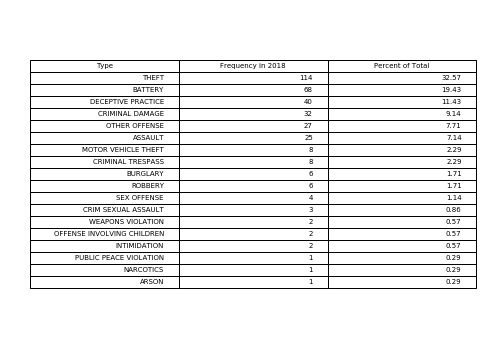

In [260]:
mk_table(probs, 'probability_table.png')

#### Part b

In [262]:
community_areas = 'https://data.cityofchicago.org/resource/igwz-8jzy.json'
nhood_dict = pull_community(community_areas)


In [318]:
gp_num = list(nhood_dict[nhood_dict['name'].str.contains('GARFIELD PARK')]['community_area'])
upt_num = list(nhood_dict[nhood_dict['name'].str.contains('UPTOWN')]['community_area'])

In [319]:
gp_filter = df2[(df2['community_area'] == gp_num[0]) | (df2['community_area'] == gp_num[1])]

upt_filter = df2[df2['community_area'] == upt_num[0]]

In [320]:
gp_counts = gp_filter.groupby('primary_type').count()[['id']]

upt_counts = upt_filter.groupby('primary_type').count()[['id']]

In [325]:
totl_theft_18 = df2[df2['primary_type'] == 'THEFT'].shape[0]

upt_pr = upt_counts.loc['THEFT']['id']/totl_theft_18
gp_pr = gp_counts.loc['THEFT']['id']/totl_theft_18
[gp_pr, upt_pr, gp_pr - upt_pr]

[0.02048185366153468, 0.015150118312282966, 0.005331735349251713]

#### Part c

There are a total of 1000 calls, 600 from Garfield Park and 400 from Uptown. Of the 600 calls from Garfield Park, 100 of them are about Battery. Of the 400 calls from Uptown, 160 are about Battery. If a call comes about Battery, how much more/less likely is it that the call came from Garfield Park versus Uptown?


In [329]:
#given:
pr_b_gp = 1/6
pr_b_up = 160/400

pr_up = 400/1000
pr_gp = 600/1000

pr_b = (100+160)/1000

In [336]:
#if call comes about Battery, prob that it is from Garfield Park:
pr_gp_b = (pr_b_gp * pr_gp)/pr_b

#if call comes about Battery, prob that it is from Uptown
pr_up_b = (pr_b_up * pr_up)/pr_b

In [337]:
{'Pr(Garfield Park | Battery)': pr_gp_b, 'Pr(Uptown | Battery)':pr_up_b}
pr_up_b - pr_gp_b

0.23076923076923095

If a call comes about Battery, it is 0.2308 less likely to have come from Garfield Park than Uptown.

In [360]:
df1.shape[0]

268098

In [ ]:
df